### Loading the necessary libraries

#### 1. Load libraries and read the data

#### 1.1. Load libraries

In [8]:
# Python libraries
# Classic,data manipulation and linear algebra
import pandas as pd
import numpy as np

# Plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.tools as tls
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import squarify

# Data processing, metrics and modeling
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix,  roc_curve, precision_recall_curve, accuracy_score, roc_auc_score
import lightgbm as lgbm
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from yellowbrick.classifier import DiscriminationThreshold

# Stats
import scipy.stats as ss
from scipy import interp
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# Time
from contextlib import contextmanager
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

#ignore warning messages 
import warnings
warnings.filterwarnings('ignore') 

In [2]:
# pip install squarify!

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install lightgbm

In [6]:
pip install yellowbrick

#### 1.2. Read data

In [12]:
data= pd.read_csv('E:/Diabetes/diabetes.csv')

In [13]:
data.head(2)

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0

#### 2. Overview

In [14]:
#Checking the data head and information
display(data.info(),data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


None

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

#### 2.2 Target distribution

In [16]:
# 2 datasets
D = data[(data['Outcome'] != 0)]
H = data[(data['Outcome'] == 0)]

#------------COUNT-----------------------
def target_count():
    trace = go.Bar( x = data['Outcome'].value_counts().values.tolist(), 
                    y = ['healthy','diabetic' ], 
                    orientation = 'h', 
                    text=data['Outcome'].value_counts().values.tolist(), 
                    textfont=dict(size=15),
                    textposition = 'auto',
                    opacity = 0.8,marker=dict(
                    color=['lightskyblue', 'gold'],
                    line=dict(color='#000000',width=1.5)))

    layout = dict(title =  'Count of Outcome variable')

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)

#------------PERCENTAGE-------------------
def target_percent():
    trace = go.Pie(labels = ['healthy','diabetic'], values = data['Outcome'].value_counts(), 
                   textfont=dict(size=15), opacity = 0.8,
                   marker=dict(colors=['lightskyblue', 'gold'], 
                               line=dict(color='#000000', width=1.5)))


    layout = dict(title =  'Distribution of Outcome variable')

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)

In [19]:
target_count()
target_percent()

In [ ]:
# The above graph shows that the data is unbalanced. The number of non-diabetic is 268 the number of diabetic patients is 500

#### 2.3. Missing values

In [20]:
data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [21]:
# Define missing plot to detect all missing values in dataset
def missing_plot(dataset, key) :
    null_feat = pd.DataFrame(len(dataset[key]) - dataset.isnull().sum(), columns = ['Count'])
    percentage_null = pd.DataFrame((len(dataset[key]) - (len(dataset[key]) - dataset.isnull().sum()))/len(dataset[key])*100, columns = ['Count'])
    percentage_null = percentage_null.round(2)

    trace = go.Bar(x = null_feat.index, y = null_feat['Count'] ,opacity = 0.8, text = percentage_null['Count'],  textposition = 'auto',marker=dict(color = '#7EC0EE',
            line=dict(color='#000000',width=1.5)))

    layout = dict(title =  "Missing Values (count & %)")

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)
    

In [22]:
# Plotting 
missing_plot(data, 'Outcome')

In [ ]:
'''
Missing values :

Insulin = 48.7% - 374
SkinThickness = 29.56% - 227
BloodPressure = 4.56% - 35
BMI = 1.43% - 11
Glucose = 0.65% - 5

'''


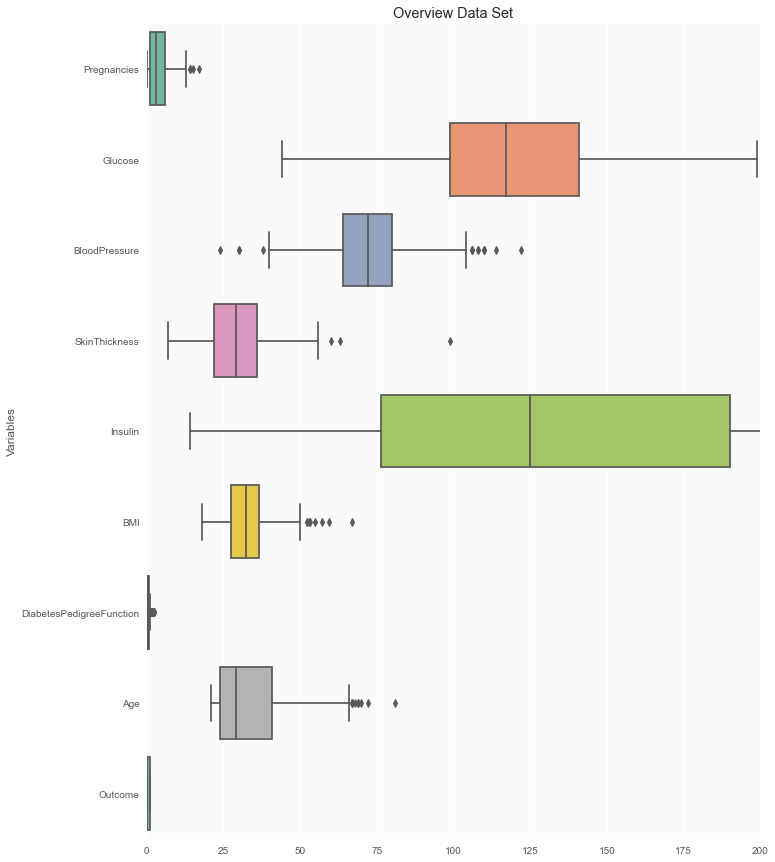

In [23]:
plt.style.use('ggplot') # Using ggplot2 style visuals 

f, ax = plt.subplots(figsize=(11, 15))

ax.set_facecolor('#fafafa')
ax.set(xlim=(-.05, 200))
plt.ylabel('Variables')
plt.title("Overview Data Set")
ax = sns.boxplot(data = data, 
  orient = 'h', 
  palette = 'Set2')

In [ ]:
'''
All missing values are encoded with NaN value

To fill these Nan values the data distribution needs to be understood against the target.
'''

In [24]:
def correlation_plot():
    #correlation
    correlation = data.corr()
    #tick labels
    matrix_cols = correlation.columns.tolist()
    #convert to array
    corr_array  = np.array(correlation)
    trace = go.Heatmap(z = corr_array,
                       x = matrix_cols,
                       y = matrix_cols,
                       colorscale='Viridis',
                       colorbar   = dict() ,
                      )
    layout = go.Layout(dict(title = 'Correlation Matrix for variables',
                            #autosize = False,
                            #height  = 1400,
                            #width   = 1600,
                            margin  = dict(r = 0 ,l = 100,
                                           t = 0,b = 100,
                                         ),
                            yaxis   = dict(tickfont = dict(size = 9)),
                            xaxis   = dict(tickfont = dict(size = 9)),
                           )
                      )
    fig = go.Figure(data = [trace],layout = layout)
    py.iplot(fig)

In [25]:
correlation_plot()

In [26]:
'''

A correlation matrix is a table showing correlation coefficients between sets of variables. 
Each random variable (Xi) in the table is correlated with each of the other values in the table (Xj). 
This allows you to see which pairs have the highest correlation.
'''

'\n\nA correlation matrix is a table showing correlation coefficients between sets of variables. \nEach random variable (Xi) in the table is correlated with each of the other values in the table (Xj). \nThis allows you to see which pairs have the highest correlation.\n'

In [ ]:
'''
Below, you can see the accuracy of LGBM with replacement of the NaN values by the variable's 
mean (same results with the median).

To replace missing values, we'll use median by target (Outcome)
'''

#### 3. Replace missing values and EDA

In [27]:
def median_target(var):   
    temp = data[data[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp

#### 3.1. Insulin

In [28]:
def plot_distribution(data_select, size_bin) :  
    # 2 datasets
    tmp1 = D[data_select]
    tmp2 = H[data_select]
    hist_data = [tmp1, tmp2]
    
    group_labels = ['diabetic', 'healthy']
    colors = ['#FFD700', '#7EC0EE']

    fig = ff.create_distplot(hist_data, group_labels, colors = colors, show_hist = True, bin_size = size_bin, curve_type='kde')
    
    fig['layout'].update(title = data_select)

    py.iplot(fig, filename = 'Density plot')

In [29]:
plot_distribution('Insulin', 0)

In [30]:
median_target('Insulin')

Outcome  Insulin
0        0    102.5
1        1    169.5

In [ ]:
'''
Insulin's medians by the target are really different ! 102.5 for a healthy person and 169.5 for a diabetic person
'''

In [32]:
data.loc[(data['Outcome'] == 0 ) & (data['Insulin'].isnull()), 'Insulin'] = 102.5
data.loc[(data['Outcome'] == 1 ) & (data['Insulin'].isnull()), 'Insulin'] = 169.5

#### 3.2. Glucose

In [ ]:
'''
Glucose : Plasma glucose concentration a 2 hours in an oral glucose tolerance test
'''

In [33]:
plot_distribution('Glucose', 0)

In [34]:
median_target('Glucose')

Outcome  Glucose
0        0    107.0
1        1    140.0

In [36]:
data.loc[(data['Outcome'] == 0 ) & (data['Glucose'].isnull()), 'Glucose'] = 107
data.loc[(data['Outcome'] == 1 ) & (data['Glucose'].isnull()), 'Glucose'] = 140

In [ ]:
'''
107 for a healthy person and 140 for a diabetic person
'''

#### 3.3. SkinThickness

In [37]:
plot_distribution('SkinThickness', 10)

In [38]:
median_target('SkinThickness')

Outcome  SkinThickness
0        0           27.0
1        1           32.0

In [40]:
data.loc[(data['Outcome'] == 0 ) & (data['SkinThickness'].isnull()), 'SkinThickness'] = 27
data.loc[(data['Outcome'] == 1 ) & (data['SkinThickness'].isnull()), 'SkinThickness'] = 32

In [ ]:
'''
27 for a healthy person and 32 for a diabetic person
'''

#### 3.4. BloodPressure

In [41]:
plot_distribution('BloodPressure', 5)

In [42]:
median_target('BloodPressure')

Outcome  BloodPressure
0        0           70.0
1        1           74.5

In [43]:
data.loc[(data['Outcome'] == 0 ) & (data['BloodPressure'].isnull()), 'BloodPressure'] = 70
data.loc[(data['Outcome'] == 1 ) & (data['BloodPressure'].isnull()), 'BloodPressure'] = 74.5

#### 3.5. BMI

In [44]:
plot_distribution('BMI', 0)

In [45]:
median_target('BMI')

Outcome   BMI
0        0  30.1
1        1  34.3

In [46]:
data.loc[(data['Outcome'] == 0 ) & (data['BMI'].isnull()), 'BMI'] = 30.1
data.loc[(data['Outcome'] == 1 ) & (data['BMI'].isnull()), 'BMI'] = 34.3

In [ ]:
'''

Age : Age (years)
DiabetesPedigreeFunction : Diabetes pedigree function
Pregnancies : Number of times pregnant

'''

In [47]:
#plot distribution 
plot_distribution('Age', 0)
plot_distribution('Pregnancies', 0)
plot_distribution('DiabetesPedigreeFunction', 0)

In [48]:
missing_plot(data, 'Outcome')

In [ ]:
# All features are complete ! Now, we can create new features

#### 4. New features (16) and EDA

In [ ]:
# Here we define 3 plot

In [51]:
def plot_feat1_feat2(feat1, feat2) :  
    D = data[(data['Outcome'] != 0)]
    H = data[(data['Outcome'] == 0)]
    trace0 = go.Scatter(
        x = D[feat1],
        y = D[feat2],
        name = 'diabetic',
        mode = 'markers', 
        marker = dict(color = '#FFD700',
            line = dict(
                width = 1)))

    trace1 = go.Scatter(
        x = H[feat1],
        y = H[feat2],
        name = 'healthy',
        mode = 'markers',
        marker = dict(color = '#7EC0EE',
            line = dict(
                width = 1)))

    layout = dict(title = feat1 +" "+"vs"+" "+ feat2,
                  yaxis = dict(title = feat2,zeroline = False),
                  xaxis = dict(title = feat1, zeroline = False)
                 )

    plots = [trace0, trace1]

    fig = dict(data = plots, layout=layout)
    py.iplot(fig)

In [52]:
def barplot(var_select, sub) :
    tmp1 = data[(data['Outcome'] != 0)]
    tmp2 = data[(data['Outcome'] == 0)]
    tmp3 = pd.DataFrame(pd.crosstab(data[var_select],data['Outcome']), )
    tmp3['% diabetic'] = tmp3[1] / (tmp3[1] + tmp3[0]) * 100

    color=['lightskyblue','gold' ]
    trace1 = go.Bar(
        x=tmp1[var_select].value_counts().keys().tolist(),
        y=tmp1[var_select].value_counts().values.tolist(),
        text=tmp1[var_select].value_counts().values.tolist(),
        textposition = 'auto',
        name='diabetic',opacity = 0.8, marker=dict(
        color='gold',
        line=dict(color='#000000',width=1)))

    
    trace2 = go.Bar(
        x=tmp2[var_select].value_counts().keys().tolist(),
        y=tmp2[var_select].value_counts().values.tolist(),
        text=tmp2[var_select].value_counts().values.tolist(),
        textposition = 'auto',
        name='healthy', opacity = 0.8, marker=dict(
        color='lightskyblue',
        line=dict(color='#000000',width=1)))
    
    trace3 =  go.Scatter(   
        x=tmp3.index,
        y=tmp3['% diabetic'],
        yaxis = 'y2',
        name='% diabetic', opacity = 0.6, marker=dict(
        color='black',
        line=dict(color='#000000',width=0.5
        )))

    layout = dict(title =  str(var_select)+' '+(sub),
              xaxis=dict(), 
              yaxis=dict(title= 'Count'), 
              yaxis2=dict(range= [-0, 75], 
                          overlaying= 'y', 
                          anchor= 'x', 
                          side= 'right',
                          zeroline=False,
                          showgrid= False, 
                          title= '% diabetic'
                         ))

    fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
    py.iplot(fig)

In [53]:
# Define pie plot to visualize each variable repartition vs target modalities : Survived or Died (train)
def plot_pie(var_select, sub) :
    D = data[(data['Outcome'] != 0)]
    H = data[(data['Outcome'] == 0)]
    
    col =['Silver', 'mediumturquoise','#CF5C36','lightblue','magenta', '#FF5D73','#F2D7EE','mediumturquoise']
    
    trace1 = go.Pie(values  = D[var_select].value_counts().values.tolist(),
                    labels  = D[var_select].value_counts().keys().tolist(),
                    textfont=dict(size=15), opacity = 0.8,
                    hole = 0.5, 
                    hoverinfo = "label+percent+name",
                    domain  = dict(x = [.0,.48]),
                    name    = "Diabetic",
                    marker  = dict(colors = col, line = dict(width = 1.5)))
    trace2 = go.Pie(values  = H[var_select].value_counts().values.tolist(),
                    labels  = H[var_select].value_counts().keys().tolist(),
                    textfont=dict(size=15), opacity = 0.8,
                    hole = 0.5,
                    hoverinfo = "label+percent+name",
                    marker  = dict(line = dict(width = 1.5)),
                    domain  = dict(x = [.52,1]),
                    name    = "Healthy" )

    layout = go.Layout(dict(title = var_select + " distribution by target <br>"+(sub),
                            annotations = [ dict(text = "Diabetic"+" : "+"268",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .22, y = -0.1),
                                            dict(text = "Healthy"+" : "+"500",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .8,y = -.1)]))
                                          

    fig  = go.Figure(data = [trace1,trace2],layout = layout)
    py.iplot(fig)

#### Glucose and Age

In [55]:
plot_feat1_feat2('Glucose','Age')

In [ ]:
# Healthy persons are concentrate with an age <= 30 and glucose <= 120

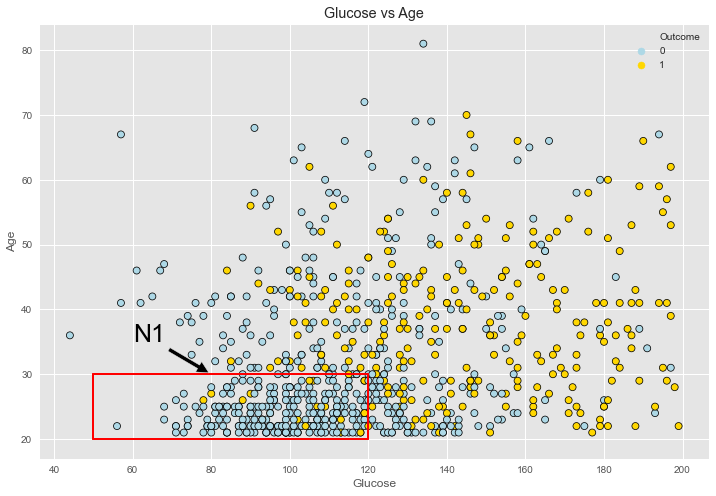

In [56]:
palette ={0 : 'lightblue', 1 : 'gold'}
edgecolor = 'black'

fig = plt.figure(figsize=(12,8))

ax1 = sns.scatterplot(x = data['Glucose'], y = data['Age'], hue = "Outcome",
                    data = data, palette = palette, edgecolor=edgecolor)

plt.annotate('N1', size=25, color='black', xy=(80, 30), xytext=(60, 35),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.plot([50, 120], [30, 30], linewidth=2, color = 'red')
plt.plot([120, 120], [20, 30], linewidth=2, color = 'red')
plt.plot([50, 120], [20, 20], linewidth=2, color = 'red')
plt.plot([50, 50], [20, 30], linewidth=2, color = 'red')
plt.title('Glucose vs Age')
plt.show()

In [57]:
data.loc[:,'N1']=0
data.loc[(data['Age']<=30) & (data['Glucose']<=120),'N1']=1

In [58]:
barplot('N1', ':Glucose <= 120 and Age <= 30')

In [59]:
plot_pie('N1', '(Glucose <= 120 and Age <= 30)')

#### BMI

In [ ]:
'''
According to wikipedia "The body mass index (BMI) or Quetelet index is a value derived from the mass (weight) 
and height of an individual. The BMI is defined as the body mass divided by the square of the body height, 
and is universally expressed in units of kg/m2, resulting from mass in kilograms and height in metres."

30 kg/m² is the limit to obesity

'''

In [60]:
data.loc[:,'N2']=0
data.loc[(data['BMI']<=30),'N2']=1

In [61]:
barplot('N2', ': BMI <= 30')

In [62]:
plot_pie('N2', 'BMI <= 30')

#### Pregnancies and Age

In [63]:
plot_feat1_feat2('Pregnancies','Age')

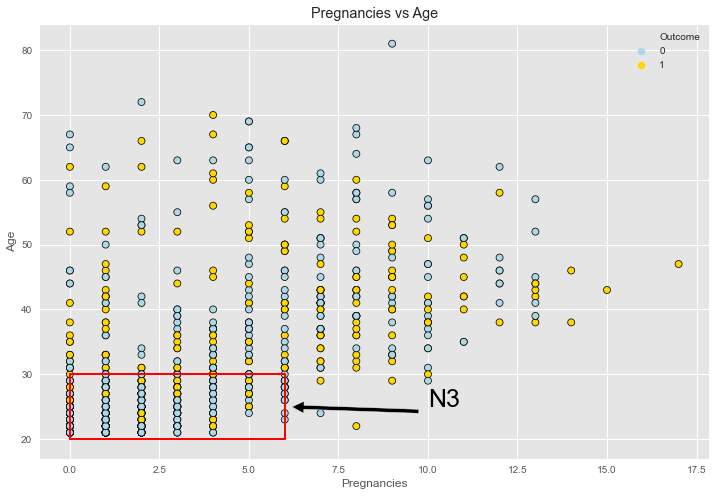

In [64]:
palette ={0 : 'lightblue', 1 : 'gold'}
edgecolor = 'black'

fig = plt.figure(figsize=(12,8))

ax1 = sns.scatterplot(x = data['Pregnancies'], y = data['Age'], hue = "Outcome",
                    data = data, palette = palette, edgecolor=edgecolor)

plt.annotate('N3', size=25, color='black', xy=(6, 25), xytext=(10, 25),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.plot([0, 6], [30, 30], linewidth=2, color = 'red')
plt.plot([6, 6], [20, 30], linewidth=2, color = 'red')
plt.plot([0, 6], [20, 20], linewidth=2, color = 'red')
plt.plot([0, 0], [20, 30], linewidth=2, color = 'red')
plt.title('Pregnancies vs Age')
plt.show()

In [65]:
data.loc[:,'N3']=0
data.loc[(data['Age']<=30) & (data['Pregnancies']<=6),'N3']=1

In [66]:
barplot('N3', ': Age <= 30 and Pregnancies <= 6')

In [67]:
plot_pie('N3', 'Age <= 30 and Pregnancies <= 6')

#### Glucose and BloodPressure

In [68]:
plot_feat1_feat2('Glucose','BloodPressure')

In [ ]:
'''
Healthy persons are concentrate with an blood pressure <= 80 and glucose <= 105
'''

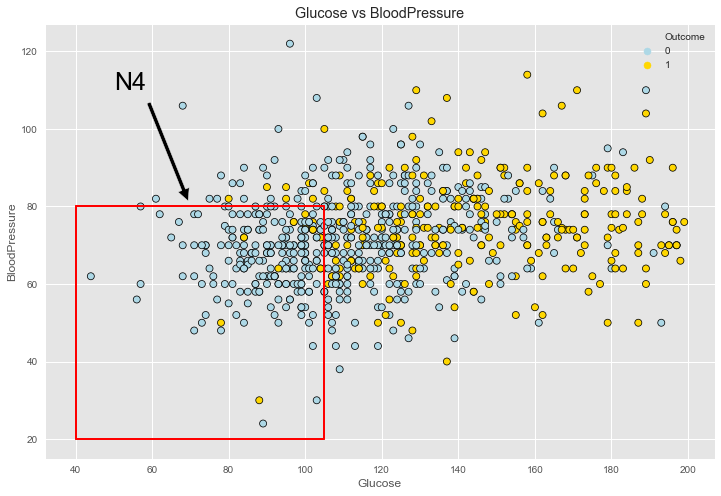

In [69]:
palette ={0 : 'lightblue', 1 : 'gold'}
edgecolor = 'black'

fig = plt.figure(figsize=(12,8))

ax1 = sns.scatterplot(x = data['Glucose'], y = data['BloodPressure'], hue = "Outcome",
                    data = data, palette = palette, edgecolor=edgecolor)

plt.annotate('N4', size=25, color='black', xy=(70, 80), xytext=(50, 110),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.plot([40, 105], [80, 80], linewidth=2, color = 'red')
plt.plot([40, 40], [20, 80], linewidth=2, color = 'red')
plt.plot([40, 105], [20, 20], linewidth=2, color = 'red')
plt.plot([105, 105], [20, 80], linewidth=2, color = 'red')
plt.title('Glucose vs BloodPressure')
plt.show()

In [70]:
data.loc[:,'N4']=0
data.loc[(data['Glucose']<=105) & (data['BloodPressure']<=80),'N4']=1

In [71]:
barplot('N4', ': Glucose <= 105 and BloodPressure <= 80')

In [72]:
plot_pie('N4', 'Glucose <= 105 and BloodPressure <= 80')

#### SkinThickness

In [73]:
data.loc[:,'N5']=0
data.loc[(data['SkinThickness']<=20) ,'N5']=1

In [74]:
barplot('N5', ':SkinThickness <= 20')

In [75]:
plot_pie('N5', 'SkinThickness <= 20')

#### SkinThickness and BMI

In [76]:
plot_feat1_feat2('SkinThickness','BMI')

In [ ]:
'''
Healthy persons are concentrate with a BMI < 30 and skin thickness <= 20
'''

In [77]:
data.loc[:,'N6']=0
data.loc[(data['BMI']<30) & (data['SkinThickness']<=20),'N6']=1

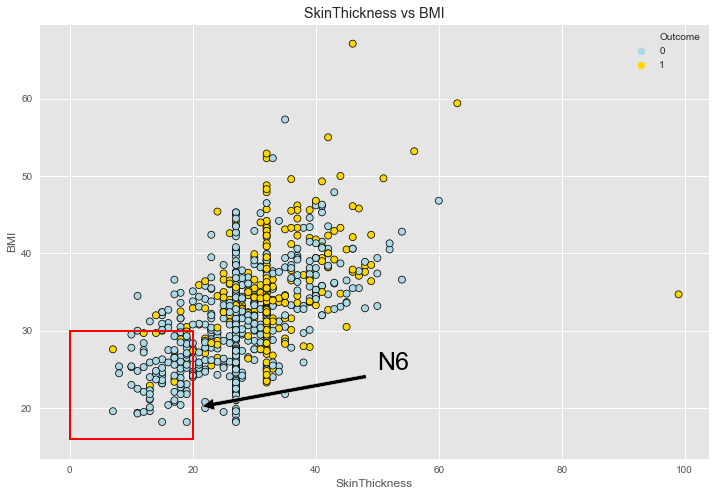

In [78]:
palette ={0 : 'lightblue', 1 : 'gold'}
edgecolor = 'black'

fig = plt.figure(figsize=(12,8))

ax1 = sns.scatterplot(x = data['SkinThickness'], y = data['BMI'], hue = "Outcome",
                    data = data, palette = palette, edgecolor=edgecolor)

plt.annotate('N6', size=25, color='black', xy=(20, 20), xytext=(50, 25),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.plot([0, 20], [30, 30], linewidth=2, color = 'red')
plt.plot([0, 0], [16, 30], linewidth=2, color = 'red')
plt.plot([0, 20], [16, 16], linewidth=2, color = 'red')
plt.plot([20, 20], [16, 30], linewidth=2, color = 'red')
plt.title('SkinThickness vs BMI')
plt.show()

In [79]:
barplot('N6', ': BMI < 30 and SkinThickness <= 20')

In [80]:
plot_pie('N6', 'BMI < 30 and SkinThickness <= 20')

#### Glucose and BMI

In [81]:
plot_feat1_feat2('Glucose','BMI')

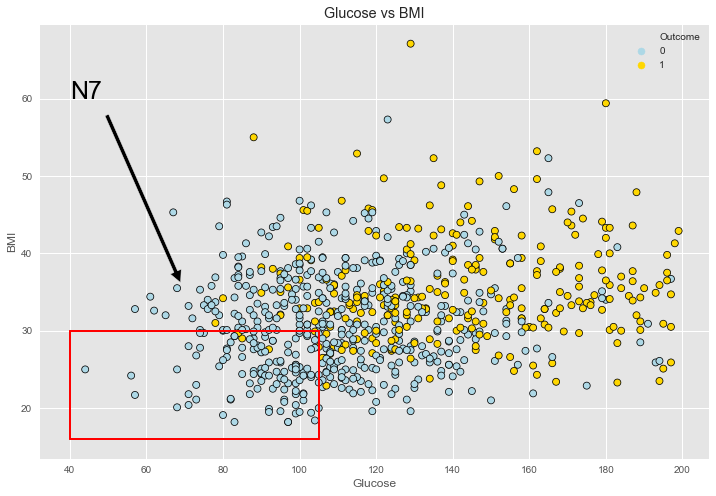

In [82]:
palette ={0 : 'lightblue', 1 : 'gold'}
edgecolor = 'black'

fig = plt.figure(figsize=(12,8))

ax1 = sns.scatterplot(x = data['Glucose'], y = data['BMI'], hue = "Outcome",
                    data = data, palette = palette, edgecolor=edgecolor)

plt.annotate('N7', size=25, color='black', xy=(70, 35), xytext=(40, 60),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.plot([105, 105], [16, 30], linewidth=2, color = 'red')
plt.plot([40, 40], [16, 30], linewidth=2, color = 'red')
plt.plot([40, 105], [16, 16], linewidth=2, color = 'red')
plt.plot([40, 105], [30, 30], linewidth=2, color = 'red')
plt.title('Glucose vs BMI')
plt.show()

In [83]:
data.loc[:,'N7']=0
data.loc[(data['Glucose']<=105) & (data['BMI']<=30),'N7']=1

In [84]:
barplot('N7', ': Glucose <= 105 and BMI <= 30')

In [85]:
plot_pie('N7', 'Glucose <= 105 and BMI <= 30')

#### Insulin 

In [86]:
plot_distribution('Insulin', 0)

In [87]:
data.loc[:,'N9']=0
data.loc[(data['Insulin']<200),'N9']=1

In [88]:
barplot('N9', ': Insulin < 200')

In [89]:
plot_pie('N9', 'Insulin < 200')

#### Blood pressure 

In [90]:
data.loc[:,'N10']=0
data.loc[(data['BloodPressure']<80),'N10']=1

In [91]:
barplot('N10', ': BloodPressure < 80')

In [92]:
plot_pie('N10', 'BloodPressure < 80')

#### Pregnancies

In [93]:
plot_distribution('Pregnancies', 0)

In [95]:
data.loc[:,'N11']=0
data.loc[(data['Pregnancies']<4) & (data['Pregnancies']!=0) ,'N11']=1

In [96]:
barplot('N11', ': Pregnancies > 0 and < 4')

In [97]:
plot_pie('N11', 'Pregnancies > 0 and < 4')

#### Others 

In [98]:
data['N0'] = data['BMI'] * data['SkinThickness']

data['N8'] =  data['Pregnancies'] / data['Age']

data['N13'] = data['Glucose'] / data['DiabetesPedigreeFunction']

data['N12'] = data['Age'] * data['DiabetesPedigreeFunction']

data['N14'] = data['Age'] / data['Insulin']

In [99]:
D = data[(data['Outcome'] != 0)]
H = data[(data['Outcome'] == 0)]

In [ ]:
# Did you watch Inception ? Here is the same! It's not a dream in a dream but a new feature extract from a new feature

In [100]:
plot_distribution('N0', 0)

In [101]:
data.loc[:,'N15']=0
data.loc[(data['N0']<1034) ,'N15']=1

In [102]:
barplot('N15', ': N0 < 1034')

In [103]:
plot_pie('N15', 'N0 < 1034')

#### 5. Prepare dataset

In [ ]:
'''
5.1. StandardScaler and LabelEncoder
'''

In [104]:
target_col = ["Outcome"]
cat_cols   = data.nunique()[data.nunique() < 12].keys().tolist()
cat_cols   = [x for x in cat_cols ]
#numerical columns
num_cols   = [x for x in data.columns if x not in cat_cols + target_col]
#Binary columns with 2 values
bin_cols   = data.nunique()[data.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols :
    data[i] = le.fit_transform(data[i])
    
#Duplicating columns for multi value columns
data = pd.get_dummies(data = data,columns = multi_cols )

#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(data[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
df_data_og = data.copy()
data = data.drop(columns = num_cols,axis = 1)
data = data.merge(scaled,left_index=True,right_index=True,how = "left")

#### 5.2. Correlation Matrix

In [105]:
def correlation_plot():
    #correlation
    correlation = data.corr()
    #tick labels
    matrix_cols = correlation.columns.tolist()
    #convert to array
    corr_array  = np.array(correlation)
    trace = go.Heatmap(z = corr_array,
                       x = matrix_cols,
                       y = matrix_cols,
                       colorscale='Viridis',
                       colorbar   = dict() ,
                      )
    layout = go.Layout(dict(title = 'Correlation Matrix for variables',
                            #autosize = False,
                            #height  = 1400,
                            #width   = 1600,
                            margin  = dict(r = 0 ,l = 100,
                                           t = 0,b = 100,
                                         ),
                            yaxis   = dict(tickfont = dict(size = 9)),
                            xaxis   = dict(tickfont = dict(size = 9)),
                           )
                      )
    fig = go.Figure(data = [trace],layout = layout)
    py.iplot(fig)

In [106]:
correlation_plot()

#### 5.3. X and y ( Features and target variable)

In [107]:
# Def X and Y
X = data.drop('Outcome', 1)
y = data['Outcome']

#### 5.4. Model Performance

In [ ]:
'''

To measure the performance of a model, we need several elements :


Confusion matrix : also known as the error matrix, allows visualization of the performance of an algorithm :

true positive (TP) : Diabetic correctly identified as diabetic
true negative (TN) : Healthy correctly identified as healthy
false positive (FP) : Healthy incorrectly identified as diabetic
false negative (FN) : Diabetic incorrectly identified as healthy


Metrics :

Accuracy : (TP +TN) / (TP + TN + FP +FN)
Precision : TP / (TP + FP)
Recall : TP / (TP + FN)
F1 score : 2 x ((Precision x Recall) / (Precision + Recall))
Roc Curve : The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) 
at various threshold settings.


Precision Recall Curve : shows the tradeoff between precision and recall for different threshold
To train and test our algorithm we'll use cross validation K-Fold

In k-fold cross-validation, the original sample is randomly partitioned into k equal sized subsamples. 
Of the k subsamples, a single subsample is retained as the validation data for testing the model, 
and the remaining k − 1 subsamples are used as training data. The cross-validation process is then repeated k times, 
with each of the k subsamples used exactly once as the validation data. The k results can then be averaged to produce a 
single estimation. The advantage of this method over repeated random sub-sampling is that all observations are used for 
both training and validation, and each observation is used for validation exactly once.

'''


In [108]:
def model_performance(model, subtitle) :   
    #Kfold
    cv = KFold(n_splits=5,shuffle=False, random_state = 42)
    y_real = []
    y_proba = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    i = 1
    
    for train,test in cv.split(X,y):
        model.fit(X.iloc[train], y.iloc[train])
        pred_proba = model.predict_proba(X.iloc[test])
        precision, recall, _ = precision_recall_curve(y.iloc[test], pred_proba[:,1])
        y_real.append(y.iloc[test])
        y_proba.append(pred_proba[:,1])
        fpr, tpr, t = roc_curve(y[test], pred_proba[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc) 
    
    # Confusion matrix
    y_pred = cross_val_predict(model, X, y, cv=5)
    conf_matrix = confusion_matrix(y, y_pred)
    trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)"],
                        y = ["0 (true)","1 (true)"],xgap = 2, ygap = 2, 
                        colorscale = 'Viridis', showscale  = False)
    
    #Show metrics
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    Precision =  (tp/(tp+fp))
    Recall    =  (tp/(tp+fn))
    F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))

    show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = (show_metrics[0].values), 
                    y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(show_metrics[0].values,4),
                    textposition = 'auto', textfont=dict(color='black'),
                    orientation = 'h', opacity = 1, marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))

    #Roc curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)

    trace3 = go.Scatter(x=mean_fpr, y=mean_tpr,
                        name = "Roc : " ,
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2), fill='tozeroy')
    trace4 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))
    
    #Precision - recall curve
    y_real = y
    y_proba = np.concatenate(y_proba)
    precision, recall, _ = precision_recall_curve(y_real, y_proba)

    trace5 = go.Scatter(x = recall, y = precision,
                        name = "Precision" + str(precision),
                        line = dict(color = ('lightcoral'),width = 2), fill='tozeroy')
    
    mean_auc=round(mean_auc,3)
    #Subplots
    fig = tls.make_subplots(rows=2, cols=2, print_grid=False,
                          specs=[[{}, {}], 
                                 [{}, {}]],
                          subplot_titles=('Confusion Matrix',
                                          'Metrics',
                                          'ROC curve'+" "+ '('+ str(mean_auc)+')',
                                          'Precision - Recall curve',
                                          ))
    #Trace and layout
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,2,1)
    fig.append_trace(trace4,2,1)
    fig.append_trace(trace5,2,2)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance report (5 folds)</b><br>'+subtitle,
                        autosize = False, height = 830, width = 830,
                        plot_bgcolor = 'black',
                        paper_bgcolor = 'black',
                        margin = dict(b = 195), font=dict(color='white'))
    fig["layout"]["xaxis1"].update(color = 'white')
    fig["layout"]["yaxis1"].update(color = 'white')
    fig["layout"]["xaxis2"].update((dict(range=[0, 1], color = 'white')))
    fig["layout"]["yaxis2"].update(color = 'white')
    fig["layout"]["xaxis3"].update(dict(title = "false positive rate"), color = 'white')
    fig["layout"]["yaxis3"].update(dict(title = "true positive rate"),color = 'white')
    fig["layout"]["xaxis4"].update(dict(title = "recall"), range = [0,1.05],color = 'white')
    fig["layout"]["yaxis4"].update(dict(title = "precision"), range = [0,1.05],color = 'white')
    for i in fig['layout']['annotations']:
        i['font'] = titlefont=dict(color='white', size = 14)
    py.iplot(fig)

#### 5.5. Scores Tables

In [ ]:
# We can complete model performance report with a table contain all results by fold

In [122]:
def scores_table(model, subtitle):
    scores = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    res = []
    for sc in scores:
        scores = cross_val_score(model, X, y, cv = 5, scoring = sc)
        res.append(scores)
    df = pd.DataFrame(res).T
    df.loc['mean'] = df.mean()
    df.loc['std'] = df.std()
    df= df.rename(columns={0: 'accuracy', 1:'precision', 2:'recall',3:'f1',4:'roc_auc'})

    trace = go.Table(
        header=dict(values=['<b>Fold', '<b>Accuracy', '<b>Precision', '<b>Recall', '<b>F1 score', '<b>Roc auc'],
                    line = dict(color='#7D7F80'),
                    fill = dict(color='#a1c3d1'),
                    align = ['center'],
                    font = dict(size = 15)),
        cells=dict(values=[('1','2','3','4','5','mean', 'std'),
                           np.round(df['accuracy'],3),
                           np.round(df['precision'],3),
                           np.round(df['recall'],3),
                           np.round(df['f1'],3),
                           np.round(df['roc_auc'],3)],
                   line = dict(color='#7D7F80'),
                   fill = dict(color='#EDFAFF'),
                   align = ['center'], font = dict(size = 15)))

    layout = dict(width=800, height=400, title = '<b>Cross Validation - 5 folds</b><br>'+subtitle, font = dict(size = 15))
    fig = dict(data=[trace], layout=layout)

    py.iplot(fig, filename = 'styled_table')
   

#### 6. Machine Learning

#### 6.1. RandomSearch + LightGBM - Accuracy = 89.8%

In [ ]:
'''


LightGBM is a gradient boosting framework that uses tree based learning algorithms.
It is designed to be distributed and efficient with the following advantages:

Faster training speed and higher efficiency.
Lower memory usage.
Better accuracy.
Support of parallel and GPU learning.
Capable of handling large-scale data.
To find the best hyperparameters, we'll use Random Search CV.

Random search is a technique where random combinations of the hyperparameters are used to find the best solution 
for the built model. Generally RS is more faster and accurate than GridSearchCV who calculate all possible combinations. 
With Random Grid we specify the number of combinations that we want

LightGBM : Hyperparameters :

learning_rate : This determines the impact of each tree on the final outcome. GBM works by starting with an initial 
estimate which is updated using the output of each tree. The learning parameter controls the magnitude of this change 
in the estimates
n_estimators : number of trees (or rounds)
num_leaves : number of leaves in full tree, default: 31
min_child_samples : minimal number of data in one leaf. Can be used to deal with over-fitting
min_child_weight : minimal sum hessian in one leaf.
subsample : randomly select part of data without resampling
max_depth : It describes the maximum depth of tree. This parameter is used to handle model overfitting.
colsample_bytree : LightGBM will randomly select part of features on each iteration if colsample_bytree smaller 
than 1.0. For example, if you set it to 0.8, LightGBM will select 80% of features before training each tree
reg_alpha : regularization
reg_lambda : regularization

early_stopping_rounds : This parameter can help you speed up your analysis. Model will stop training if one metric of one 
validation data doesn’t improve in last early_stopping_round rounds. This will reduce excessive iterations



'''

In [110]:
random_state=42

fit_params = {"early_stopping_rounds" : 100, 
             "eval_metric" : 'auc', 
             "eval_set" : [(X,y)],
             'eval_names': ['valid'],
             'verbose': 0,
             'categorical_feature': 'auto'}

param_test = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
              'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000],
              'num_leaves': sp_randint(6, 50), 
              'min_child_samples': sp_randint(100, 500), 
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              'subsample': sp_uniform(loc=0.2, scale=0.8), 
              'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7],
              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

#number of combinations
n_iter = 300

#intialize lgbm and lunch the search
lgbm_clf = lgbm.LGBMClassifier(random_state=random_state, silent=True, metric='None', n_jobs=4)
grid_search = RandomizedSearchCV(
    estimator=lgbm_clf, param_distributions=param_test, 
    n_iter=n_iter,
    scoring='accuracy',
    cv=5,
    refit=True,
    random_state=random_state,
    verbose=True)

grid_search.fit(X, y, **fit_params)
opt_parameters =  grid_search.best_params_
lgbm_clf = lgbm.LGBMClassifier(**opt_parameters)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:  1.8min finished


In [123]:
model_performance(lgbm_clf, 'LightGBM')
scores_table(lgbm_clf, 'LightGBM')

#### 6.2. LightGBM - Discrimination Threshold

In [ ]:
'''

Discrimination Threshold : A visualization of precision, recall, f1 score, and queue rate with respect to the 
discrimination threshold of a binary classifier. The discrimination threshold is the probability or score at 
which the positive class is chosen over the negative class

'''

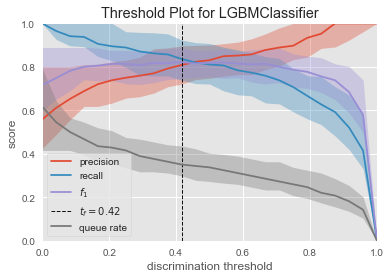

In [112]:
visualizer = DiscriminationThreshold(lgbm_clf)

visualizer.fit(X, y)  
visualizer.poof() 

#### 6.3. GridSearch + LightGBM & KNN- 

In [ ]:
'''
We obtain a really good result but we can beat 90% with adding a KNeighborsClassifier to LightGBM (Voting Classifier)

KNeighborsClassifier : KNeighborsClassifier implements learning based on the k nearest neighbors of each query point, 
where k is an integer value specified by the user.

VotingClassifier : VotingClassifier is a meta-classifier for combining similar or conceptually different machine 
learning classifiers for classification via majority or plurality voting

With GridSearch CV we search the best "n_neighbors" to optimize accuracy of Voting Classifier

'''

In [126]:
knn_clf = KNeighborsClassifier()

voting_clf = VotingClassifier(estimators=[ 
    ('lgbm_clf', lgbm_clf),
    ('knn', KNeighborsClassifier())], voting='soft', weights = [1,1])

params = {
      'knn__n_neighbors': np.arange(1,30)
      }
      
grid = GridSearchCV(estimator=voting_clf, param_grid=params, cv=5)

grid.fit(X,y)

print("Best Score:" + str(grid.best_score_))
print("Best Parameters: " + str(grid.best_params_))

Best Score:0.8906883965707495
Best Parameters: {'knn__n_neighbors': 18}


#### With n_neighbors = 18, the accuracy increase to 0.89068 ! Bellow the model performance report

In [117]:
knn_clf = KNeighborsClassifier(n_neighbors = 18)

voting_clf = VotingClassifier (
        estimators = [('knn', knn_clf), ('lgbm', lgbm_clf)],
                     voting='soft', weights = [1,1])

In [118]:
model_performance(voting_clf, 'LightGBM & KNN')
scores_table(voting_clf, 'LightGBM & KNN')

#### 6.4. LightGBM & KNN - Discrimination Threshold

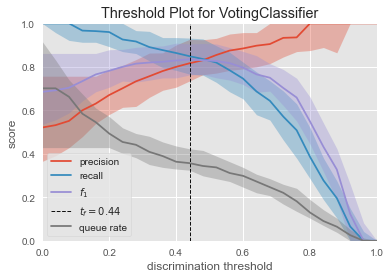

In [119]:
visualizer = DiscriminationThreshold(voting_clf)

visualizer.fit(X, y)  
visualizer.poof() 